In [1]:
from pyspark.sql import SQLContext
import plotly.plotly as py
from plotly.graph_objs import *
import matplotlib.pyplot as plt
import numpy as np
import requests

In [2]:
YELP_BUSINESSES = 'yelp_business.csv'

In [3]:
rdd = sc.textFile(YELP_BUSINESSES, use_unicode=False).cache()

In [4]:
rdd.take(10)

['business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories',
 'FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",,"""4855 E Warner Rd, Ste B9""",Ahwatukee,AZ,85044,33.3306902,-111.9785992,4.0,22,1,Dentists;General Dentistry;Health & Medical;Oral Surgeons;Cosmetic Dentists;Orthodontists',
 'He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",,"""3101 Washington Rd""",McMurray,PA,15317,40.2916853,-80.1048999,3.0,11,1,Hair Stylists;Hair Salons;Men\'s Hair Salons;Blow Dry/Out Services;Hair Extensions;Beauty & Spas',
 'KQPW8lFf1y5BT2MxiSZ3QA,"""Western Motor Vehicle""",,"""6025 N 27th Ave, Ste 1""",Phoenix,AZ,85017,33.5249025,-112.1153098,1.5,18,1,Departments of Motor Vehicles;Public Services & Government',
 '8DShNS-LuFqpEWIp0HxijA,"""Sports Authority""",,"""5000 Arizona Mills Cr, Ste 435""",Tempe,AZ,85282,33.3831468,-111.9647254,3.0,9,0,Sporting Goods;Shopping',
 'PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",,"""581 Howe Ave"""

In [5]:
YELP_REVIEWS = 'yelp_review.csv'

In [6]:
rdd2 = sc.textFile(YELP_REVIEWS, use_unicode=False).cache()

In [7]:
rdd2.take(10)

['"review_id","user_id","business_id","stars","date","text","useful","funny","cool"',
 '"vkVSCC7xljjrAI4UGfnKEQ","bv2nCi5Qv5vroFiqKGopiw","AEx2SYEUJmTxVVB18LlCwA","5","2016-05-28","Super simple place but amazing nonetheless. It\'s been around since the 30\'s and they still serve the same thing they started with: a bologna and salami sandwich with mustard. ',
 '',
 'Staff was very helpful and friendly.","0","0","0"',
 '"n6QzIUObkYshz4dz2QRJTw","bv2nCi5Qv5vroFiqKGopiw","VR6GpWIda3SfvPC-lg9H3w","5","2016-05-28","Small unassuming place that changes their menu every so often. Cool decor and vibe inside their 30 seat restaurant. Call for a reservation. ',
 '',
 'We had their beef tartar and pork belly to start and a salmon dish and lamb meal for mains. Everything was incredible! I could go on at length about how all the listed ingredients really make their dishes amazing but honestly you just need to go. ',
 '',
 'A bit outside of downtown montreal but take the metro out and it\'s less than 

In [8]:
def parseCSV(idx, part):
    import csv
    if idx==0:
        part.next()
    for p in csv.reader(part):
        flag = True
        try:
            float(p[8])
            float(p[7])
        except ValueError:
            flag = False
            print "cant conver to float"
        if(flag):
            City,State,longitude,latitude = p[4],p[5],float(p[8]),float(p[7])
            yield City,State,longitude,latitude        

In [9]:
location_rdd = rdd.mapPartitionsWithIndex(parseCSV)

In [10]:
type(location_rdd)

pyspark.rdd.PipelinedRDD

In [11]:
location_rdd.take(1)

[('Ahwatukee', 'AZ', -111.9785992, 33.3306902)]

In [12]:
locations = location_rdd.toDF()

In [13]:
locations.show(4)

+---------+---+------------+----------+
|       _1| _2|          _3|        _4|
+---------+---+------------+----------+
|Ahwatukee| AZ|-111.9785992|33.3306902|
| McMurray| PA| -80.1048999|40.2916853|
|  Phoenix| AZ|-112.1153098|33.5249025|
|    Tempe| AZ|-111.9647254|33.3831468|
+---------+---+------------+----------+
only showing top 4 rows



In [14]:
locations = locations.select(locations['_1'].alias('City'),
                             locations['_2'].alias('State'),
                             locations['_3'].alias('Longitude'),
                             locations['_4'].alias('Latitude'))

Las_Vegas = locations.filter(locations.City == "Las Vegas")
Phoenix   = locations.filter(locations.City == "Phoenix")
Toronto   = locations.filter(locations.City == "Toronto")
Charlotte = locations.filter(locations.City == "Charlotte")
Stuttgart = locations.filter(locations.City == "Stuttgart")
Edinburgh = locations.filter(locations.City == "Edinburgh")

In [15]:
Charlotte.show(4)

+---------+-----+-----------+----------+
|     City|State|  Longitude|  Latitude|
+---------+-----+-----------+----------+
|Charlotte|   NC|-80.8393449|35.2216474|
|Charlotte|   NC| -80.855785| 35.220211|
|Charlotte|   NC| -80.726487| 35.147422|
|Charlotte|   NC|-80.8492598|35.1608893|
+---------+-----+-----------+----------+
only showing top 4 rows



In [16]:
Toronto.show(4)

+-------+-----+--------------+-------------+
|   City|State|     Longitude|     Latitude|
+-------+-----+--------------+-------------+
|Toronto|   ON|   -79.3993388|   43.7113993|
|Toronto|   ON|-79.4195331865|43.6398633116|
|Toronto|   ON|   -79.3269639|   43.6828673|
|Toronto|   ON|   -79.3359022|   43.6692562|
+-------+-----+--------------+-------------+
only showing top 4 rows



### Las Vegas

In [17]:
LVlong_list = Las_Vegas.select("Longitude").rdd.flatMap(lambda x: x).collect()
LVlat_list = Las_Vegas.select("Latitude").rdd.flatMap(lambda x: x).collect()

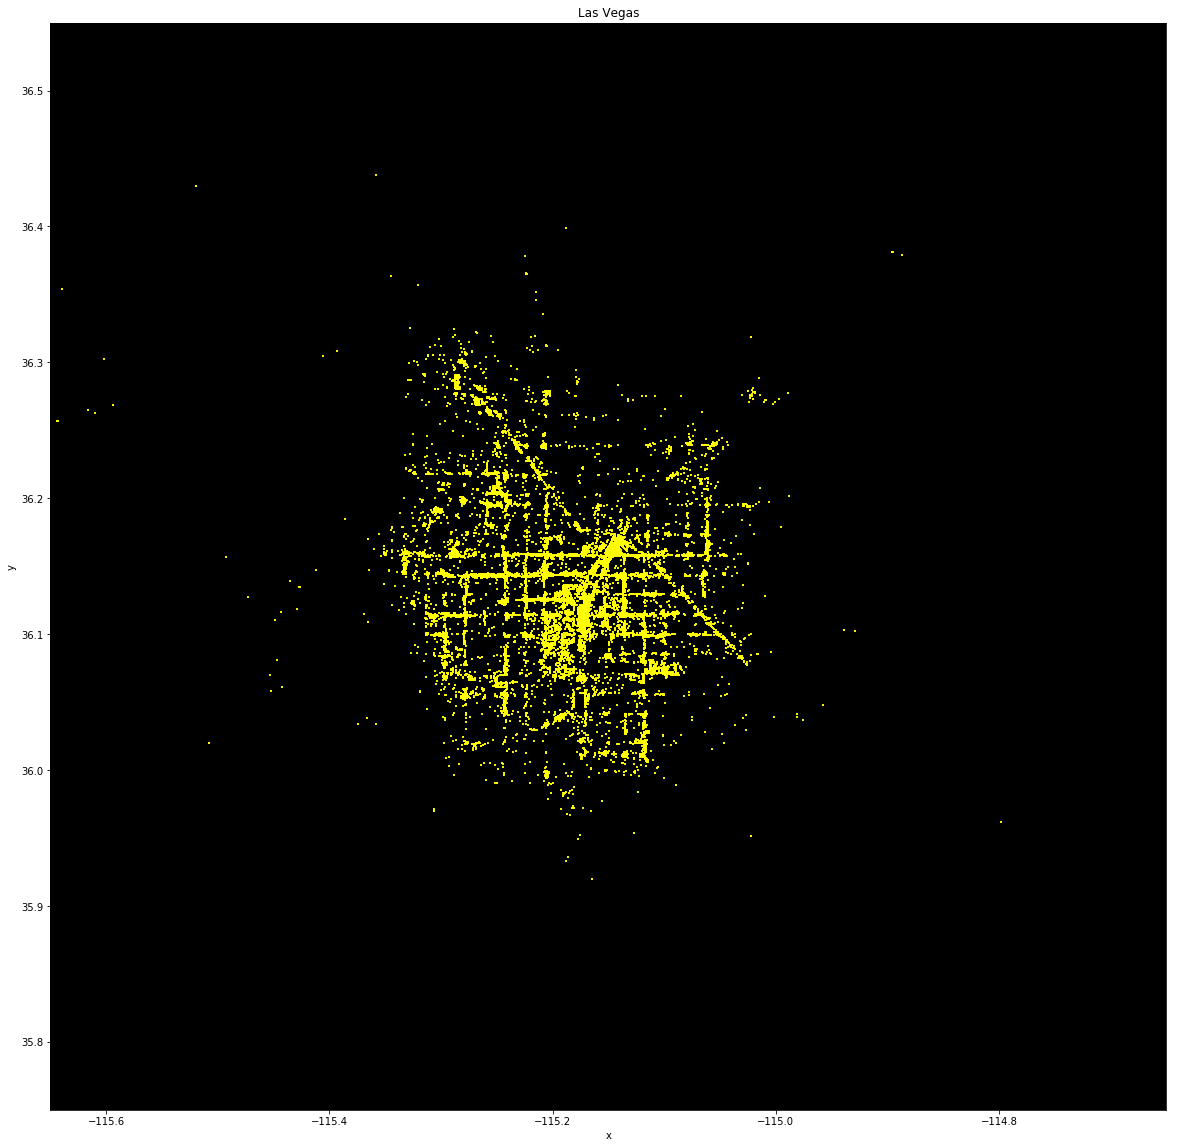

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,20))
#ax = fig.add_subplot(1, 1, 1)

ax.scatter(LVlong_list,LVlat_list,color="yellow",alpha=1,marker='s',s=1,)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Las Vegas')
ax.set_xlim(xmin=-115.5-0.15)
ax.set_xlim(xmax=-114.8+0.15)
ax.set_ylim(ymin=35.9-0.15)
ax.set_ylim(ymax=36.4+0.15)
ax.set_facecolor("black")
plt.show()

### Phoenix

In [19]:
Plong_list = Phoenix.select("Longitude").rdd.flatMap(lambda x: x).collect()
Plat_list = Phoenix.select("Latitude").rdd.flatMap(lambda x: x).collect()

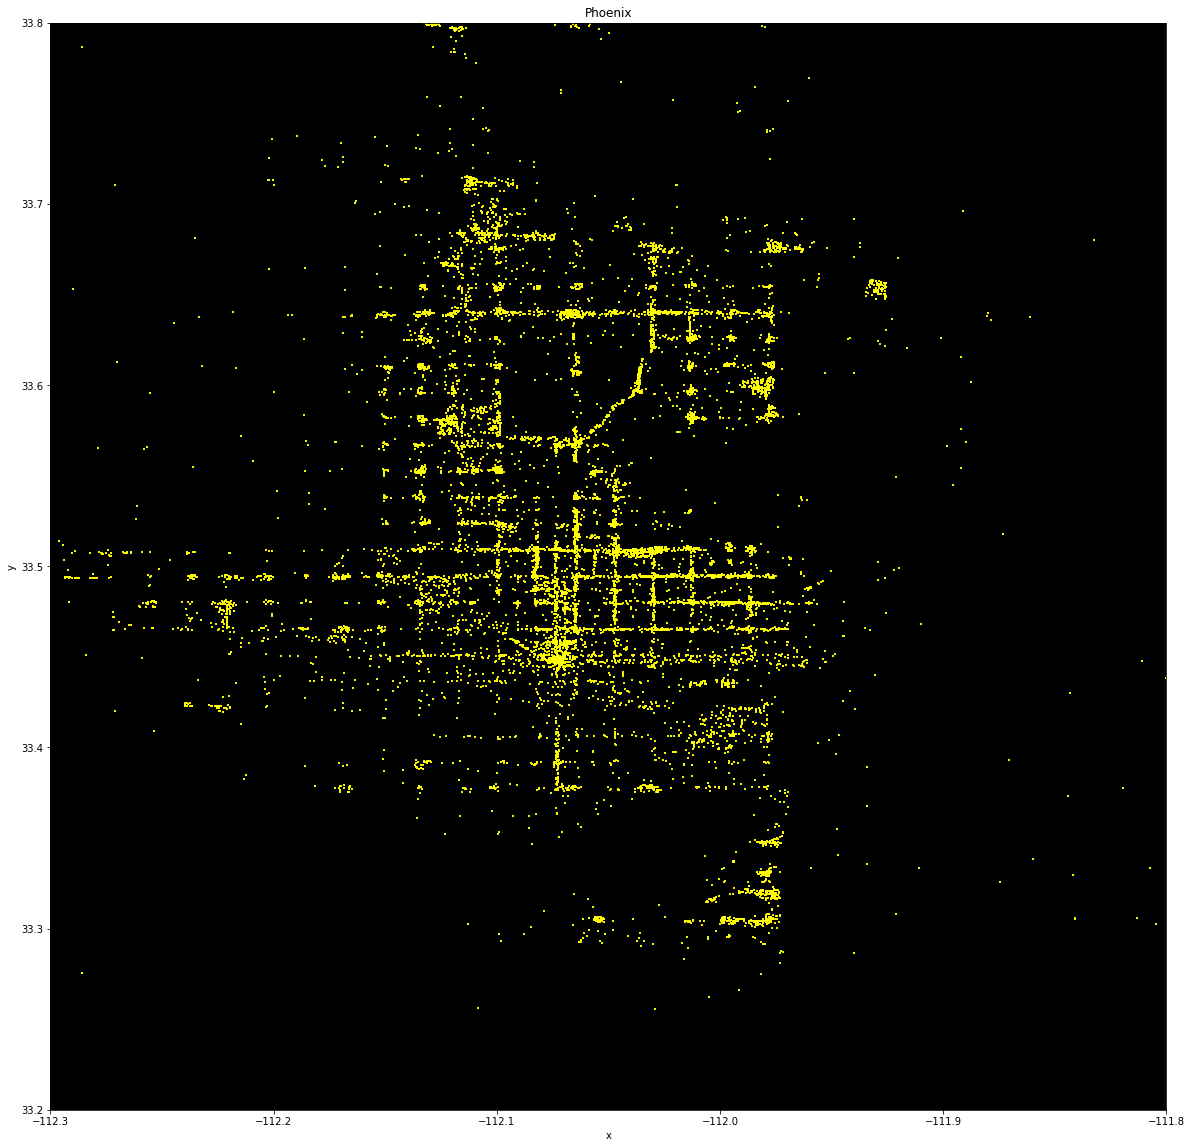

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,20))
#ax = fig.add_subplot(1, 1, 1)

ax.scatter(Plong_list,Plat_list,color="yellow",alpha=1,marker='s',s=1,)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Phoenix')
ax.set_xlim(xmin=-112.3)
ax.set_xlim(xmax=-111.8)
ax.set_ylim(ymin=33.2)
ax.set_ylim(ymax=33.8)
ax.set_facecolor("black")
plt.show()

### Toronto

In [21]:
Tlong_list = Toronto.select("Longitude").rdd.flatMap(lambda x: x).collect()
Tlat_list = Toronto.select("Latitude").rdd.flatMap(lambda x: x).collect()

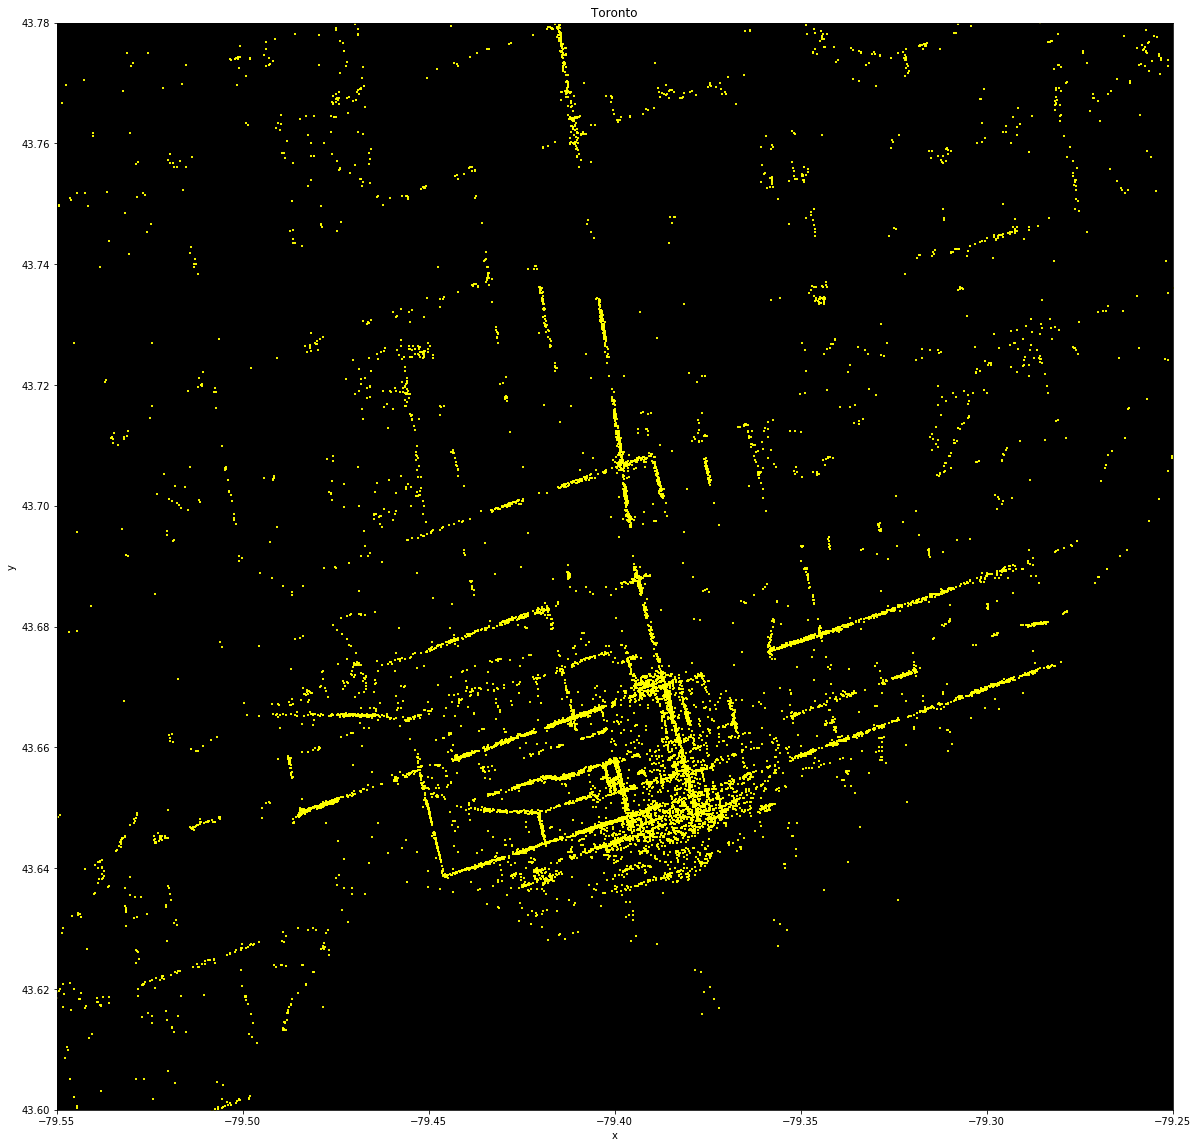

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,20))
#ax = fig.add_subplot(1, 1, 1)

ax.scatter(Tlong_list,Tlat_list,color="yellow",alpha=1,marker='s',s=1,)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Toronto')
ax.set_xlim(xmin=-79.55) #longitude
ax.set_xlim(xmax=-79.25)
ax.set_ylim(ymin=43.6) #latitude
ax.set_ylim(ymax=43.78)
ax.set_facecolor("black")
plt.show()

### Charlotte

In [23]:
Clong_list = Charlotte.select("Longitude").rdd.flatMap(lambda x: x).collect()
Clat_list = Charlotte.select("Latitude").rdd.flatMap(lambda x: x).collect()

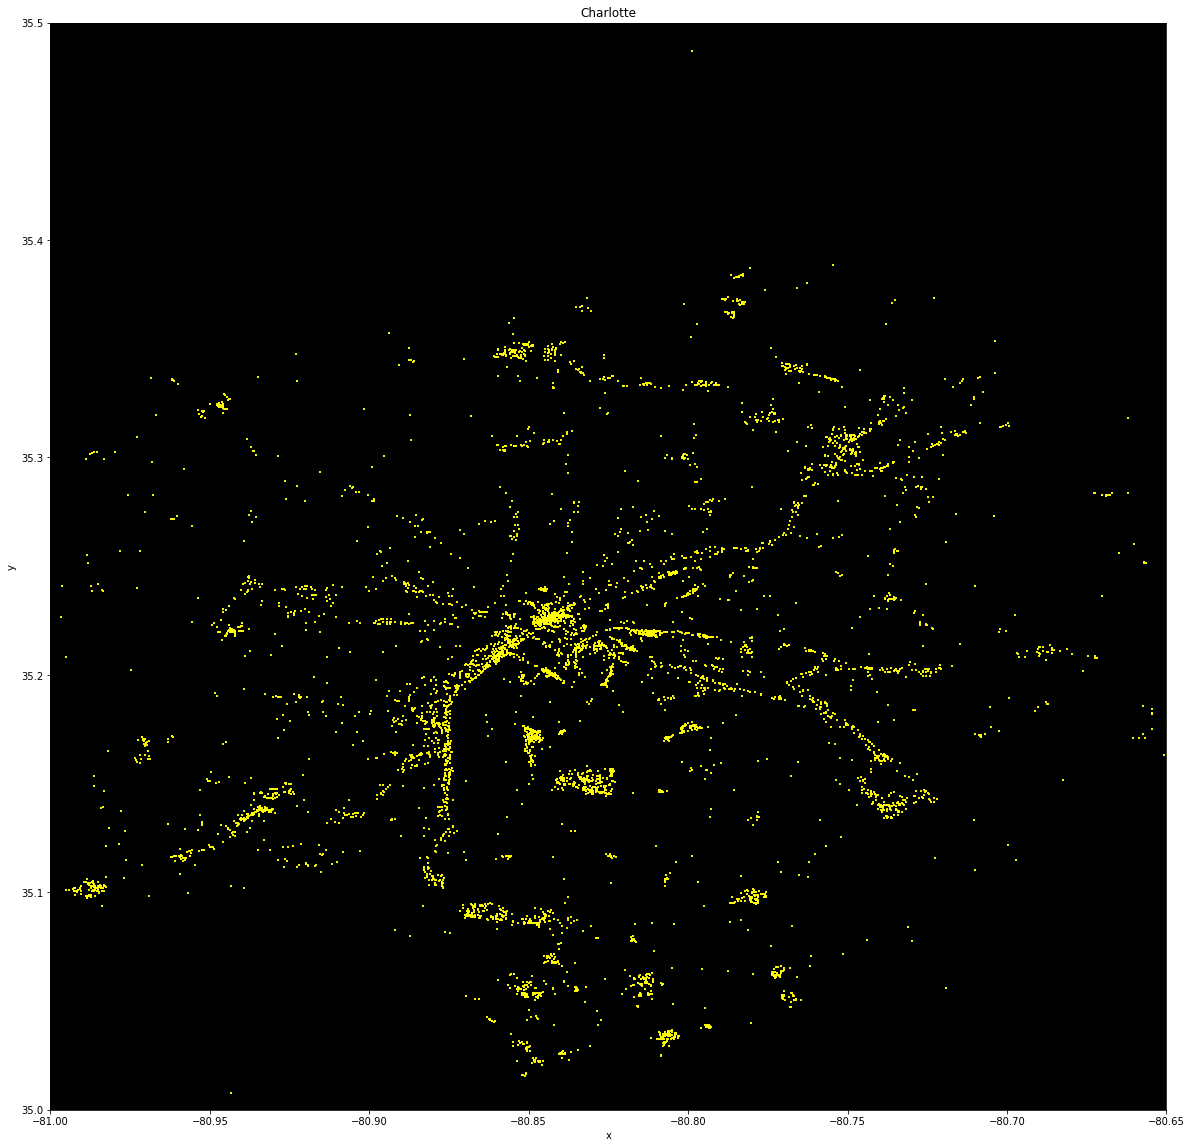

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,20))
#ax = fig.add_subplot(1, 1, 1)

ax.scatter(Clong_list,Clat_list,color="yellow",alpha=1,marker='s',s=1,)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Charlotte')
ax.set_xlim(xmin=-81.00)
ax.set_xlim(xmax=-80.65)
ax.set_ylim(ymin=35.0)
ax.set_ylim(ymax=35.5)
ax.set_facecolor("black")
plt.show()

### Stuttgart

In [25]:
Slong_list = Stuttgart.select("Longitude").rdd.flatMap(lambda x: x).collect()
Slat_list = Stuttgart.select("Latitude").rdd.flatMap(lambda x: x).collect()

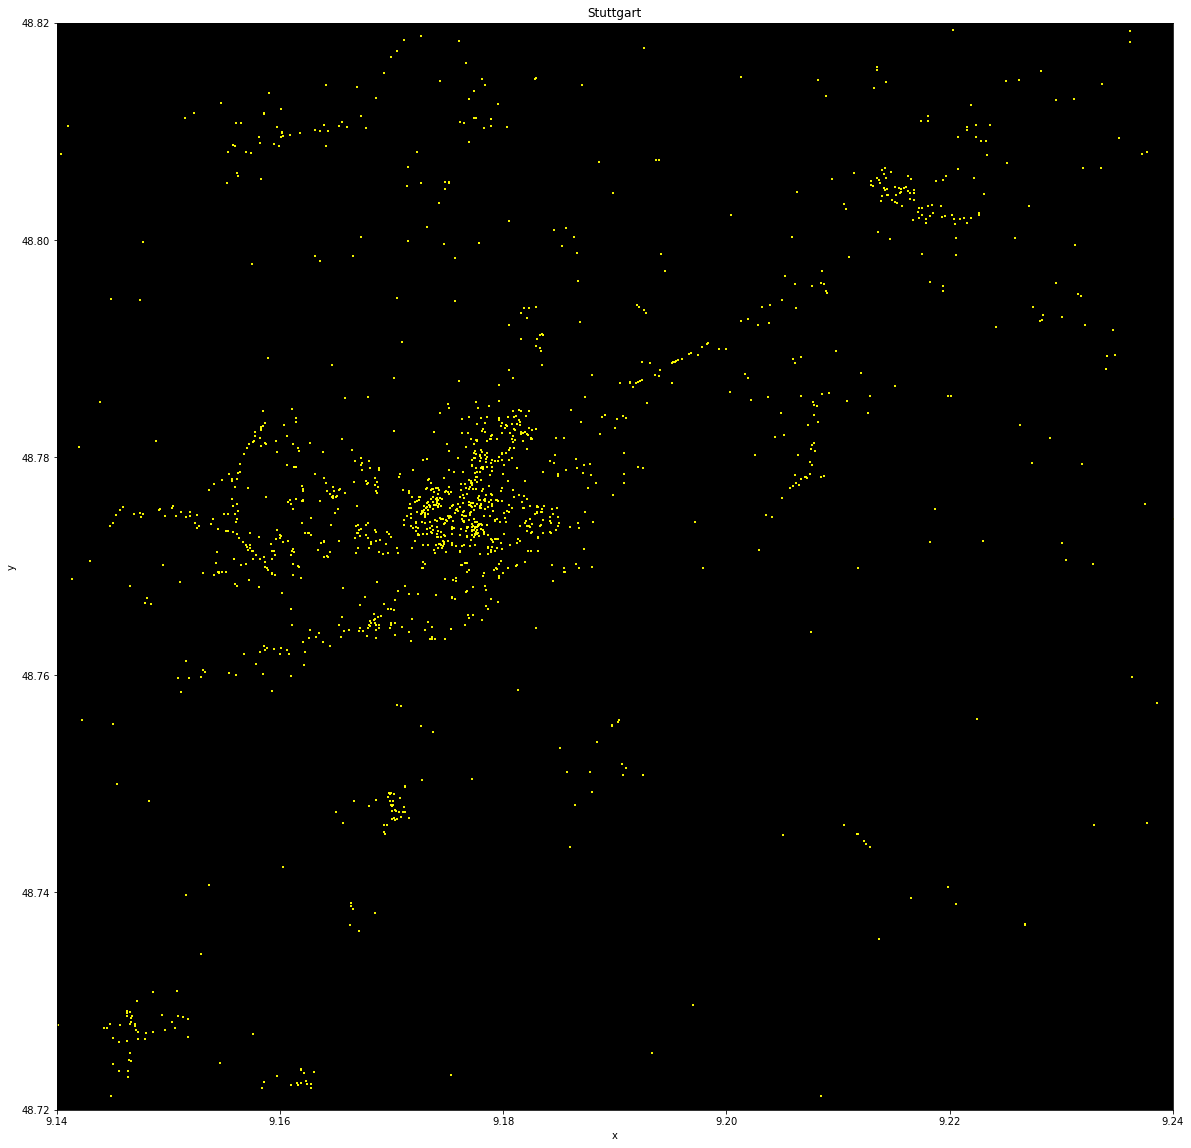

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,20))
#ax = fig.add_subplot(1, 1, 1)

ax.scatter(Slong_list,Slat_list,color="yellow",alpha=1,marker='s',s=1,)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Stuttgart')
ax.set_xlim(xmin=9.14)
ax.set_xlim(xmax=9.24)
ax.set_ylim(ymin=48.72)
ax.set_ylim(ymax=48.82)
ax.set_facecolor("black")
plt.show()

### Edinburgh

In [27]:
Elong_list = Edinburgh.select("Longitude").rdd.flatMap(lambda x: x).collect()
Elat_list = Edinburgh.select("Latitude").rdd.flatMap(lambda x: x).collect()

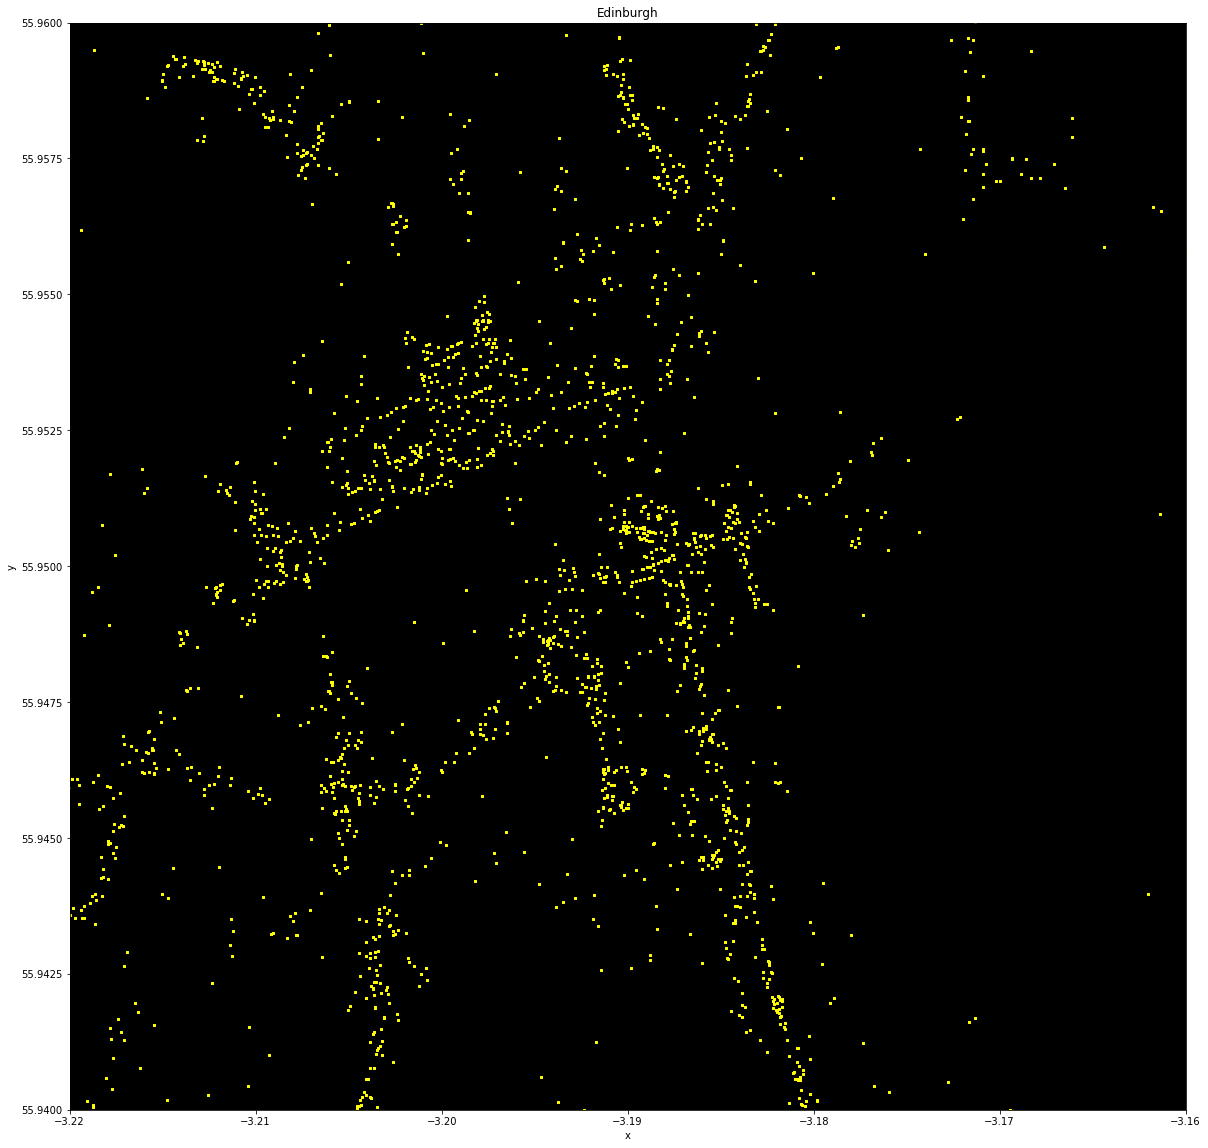

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,20))
#ax = fig.add_subplot(1, 1, 1)

ax.scatter(Elong_list,Elat_list,color="yellow",alpha=1,marker='s',s=2,)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Edinburgh')
ax.set_xlim(xmin=-3.22)
ax.set_xlim(xmax=-3.16)
ax.set_ylim(ymin=55.940)
ax.set_ylim(ymax=55.960)
ax.set_facecolor("black")
plt.show()

# Year to Year Increase of Yelp

In [29]:
REVIEW_FN ='yelp_review.csv'

In [30]:
def extract_row(index, lines):
    """
    Yield a row of strings that has been parsed
    correctly by the CSV reader.
    
    Only rows with nine elements are valid as per
    the schema of the original CSV file
    """
    import csv
    
    if index == 0:
        lines.next()
        
    reader = csv.reader(lines)
    for row in reader:
        if len(row) == 9:
            yield row

In [31]:
# Create an RDD that correctly parses the Yelp review dataset
reviews_rdd = sc.textFile(REVIEW_FN, use_unicode=False) \
                .mapPartitionsWithIndex(extract_row)

In [32]:
years = reviews_rdd.toDF()

In [33]:
years.show(4)

+--------------------+--------------------+--------------------+---+----------+--------------------+---+---+---+
|                  _1|                  _2|                  _3| _4|        _5|                  _6| _7| _8| _9|
+--------------------+--------------------+--------------------+---+----------+--------------------+---+---+---+
|vkVSCC7xljjrAI4UG...|bv2nCi5Qv5vroFiqK...|AEx2SYEUJmTxVVB18...|  5|2016-05-28|Super simple plac...|  0|  0|  0|
|n6QzIUObkYshz4dz2...|bv2nCi5Qv5vroFiqK...|VR6GpWIda3SfvPC-l...|  5|2016-05-28|Small unassuming ...|  0|  0|  0|
|MV3CcKScW05u5LVfF...|bv2nCi5Qv5vroFiqK...|CKC0-MOWMqoeWf6s-...|  5|2016-05-28|Lester's is locat...|  0|  0|  0|
|IXvOzsEMYtiJI0CAR...|bv2nCi5Qv5vroFiqK...|ACFtxLv8pGrrxMm6E...|  4|2016-05-28|Love coming here....|  0|  0|  0|
+--------------------+--------------------+--------------------+---+----------+--------------------+---+---+---+
only showing top 4 rows



In [34]:
from pyspark.sql.types import *
years = years.select(years['_1'].alias('review_id'),
                     years['_2'].alias('user_id'),
                     years['_3'].alias('business_id'),
                     years['_4'].alias('stars'),
                     years['_5'].alias('date'),
                     years['_6'].alias('text'),
                     years['_7'].alias('useful'),
                     years['_8'].alias('funny'),
                     years['_9'].alias('cool'))
years.show()

+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+
|           review_id|             user_id|         business_id|stars|      date|                text|useful|funny|cool|
+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+
|vkVSCC7xljjrAI4UG...|bv2nCi5Qv5vroFiqK...|AEx2SYEUJmTxVVB18...|    5|2016-05-28|Super simple plac...|     0|    0|   0|
|n6QzIUObkYshz4dz2...|bv2nCi5Qv5vroFiqK...|VR6GpWIda3SfvPC-l...|    5|2016-05-28|Small unassuming ...|     0|    0|   0|
|MV3CcKScW05u5LVfF...|bv2nCi5Qv5vroFiqK...|CKC0-MOWMqoeWf6s-...|    5|2016-05-28|Lester's is locat...|     0|    0|   0|
|IXvOzsEMYtiJI0CAR...|bv2nCi5Qv5vroFiqK...|ACFtxLv8pGrrxMm6E...|    4|2016-05-28|Love coming here....|     0|    0|   0|
|L_9BTb55X0GDtThi6...|bv2nCi5Qv5vroFiqK...|s2I_Ni76bjJNK9yG6...|    4|2016-05-28|Had their chocola...|     0|    0|   0|
|HRPm3vEZ_F-33TYVT...|_4iMDXbXZ1

In [35]:
date = years.select(years['date'].cast(DateType()))
#date = date.cast(DataType())
date.show(25)

+----------+
|      date|
+----------+
|2016-05-28|
|2016-05-28|
|2016-05-28|
|2016-05-28|
|2016-05-28|
|2014-09-24|
|2012-05-11|
|2015-10-27|
|2013-02-09|
|2016-04-06|
|2013-05-01|
|2011-09-28|
|2011-02-16|
|2012-12-03|
|2010-07-16|
|2011-09-28|
|2012-10-23|
|2010-09-15|
|2012-09-23|
|2012-10-30|
|2012-10-19|
|2011-10-14|
|2013-07-01|
|2012-05-10|
|2012-09-23|
+----------+
only showing top 25 rows

